In [19]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


In [ ]:
df = pd.read_csv('data.csv', sep=';')

In [29]:
df['Cod_cmd'].value_counts().count()

404939

In [31]:
# Get the most common Univers and Nature for each product
product_categories = df.groupby('Libellé produit').agg({
    'Univers': lambda x: x.mode().iat[0] if not x.mode().empty else None,
    'Nature': lambda x: x.mode().iat[0] if not x.mode().empty else None
}).reset_index()

df_unique_products = product_categories[['Libellé produit', 'Univers', 'Nature']]

print("Number of unique products:", len(df_unique_products))
df_unique_products.head()


Number of unique products: 56018


,Libellé produit,Univers,Nature
0,40 742 ensemble 5 en 1 tondeuse et regle barb...,Petit Electroménager,Tondeuse multistyle
1,60cm fronton applique mural style arbre de vi...,Décoration Textile,Objet deco
2,9 vip pets vague 1,Enfant Bébé,Poupée et poupon
3,agère murale hwc h37 étagère suspendue tiroir...,Canapé Salon Séjour,Etagère
4,allan canapé 3 places convertible ouverture e...,Petit Electroménager,Friteuse


In [1]:
df_unique_products.to_csv('unique_products.csv', index=False)

NameError: name 'df_unique_products' is not defined

In [17]:
df = pd.read_csv('unique_products.csv')
df.sample(10)

,Libellé produit,Univers,Nature
45186,Sommier tapissier 130x190 gris fabrique en france,Chambre Literie,Sommier
47604,Table basse jeny 115 x 65 x 40 cm blanc,Canapé Salon Séjour,Table basse
16637,Etagère à chaussures superposable 6 paires 67 x 31 cm noir,Bureau Rangement,Meuble à chaussures
25835,Lit enfant anna m 70x140cm +tiroir+matelas+sommier,Enfant Bébé,Lit jeune
18290,Fmd bureau avec 1 tiroir 123 x 50 x 76 5 cm béton et blanc,Bureau Rangement,Bureau
21538,Icaverne fixations et meubles de rangement multimédia serie armoire à cd noir brillant 21x20x88 cm aggloméré,Jardin Loisirs Sport,Visserie consommable
36159,Oreiller duvet plumettes 65x65 cm,Chambre Literie,Oreiller
22893,Klarstein chateaubriand nuovo appareil à raclette pour 8 grill 1200w pierre in,Petit Electroménager,Appareil à raclette
16917,FURNIX meuble tv élégant 100 cm Blois I blanc noir avec LED,Canapé Salon Séjour,Meuble tv
10723,Chevet bois teck japonais 2 tiroirs,Chambre Literie,Chevet


In [4]:
df['Nature'].value_counts().count()

594

In [ ]:
df[df['Nature'] == 'Colonne sdb']['Libellé produit']

In [5]:
import sys, subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "tokenizers", "scikit-learn"])


0

In [6]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.normalizers import NFD, Lowercase, StripAccents, Sequence
from tokenizers.processors import TemplateProcessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import os

# Ensure df is loaded (from earlier cells). Expect columns: 'Libellé produit', 'Nature'
assert 'df' in globals(), "DataFrame df must be loaded earlier."
assert {'Libellé produit','Nature'}.issubset(df.columns), "df must have 'Libellé produit' and 'Nature' columns"

# Use the deduplicated products if available
if 'df_unique_products' in globals():
    data_df = df_unique_products.rename(columns={'Libellé produit': 'label', 'Nature': 'target'})
else:
    data_df = df.rename(columns={'Libellé produit': 'label', 'Nature': 'target'})[['label','target']].dropna()

# Basic cleaning: drop rows with missing or empty labels/targets
data_df = data_df.dropna(subset=['label','target'])
data_df = data_df[(data_df['label'].astype(str).str.strip()!='') & (data_df['target'].astype(str).str.strip()!='')]

# Prepare corpus for BPE
corpus = data_df['label'].astype(str).tolist()

# Initialize BPE tokenizer
bpe_tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
bpe_tokenizer.normalizer = Sequence([NFD(), Lowercase(), StripAccents()])
bpe_tokenizer.pre_tokenizer = Whitespace()

# Special tokens and training
special_tokens = ["[PAD]", "[UNK]"]
trainer = BpeTrainer(vocab_size=20000, min_frequency=2, special_tokens=special_tokens)

bpe_tokenizer.train_from_iterator(corpus, trainer=trainer)

# Post-processor for consistent BOS/EOS if desired (not necessary for bag-of-tokens)
bpe_tokenizer.post_processor = TemplateProcessing(
    single="$0",
    pair="$A $B",
    special_tokens=[("[PAD]", 0), ("[UNK]", 1)]
)

# Save to disk to reuse later
bpe_dir = "./artifacts"
os.makedirs(bpe_dir, exist_ok=True)
bpe_path = os.path.join(bpe_dir, "bpe_tokenizer.json")
bpe_tokenizer.save(bpe_path)

print(f"Trained BPE tokenizer with vocab size: {bpe_tokenizer.get_vocab_size()} and saved to {bpe_path}")





Trained BPE tokenizer with vocab size: 20000 and saved to ./artifacts/bpe_tokenizer.json


In [ ]:
# Build vocabulary mapping from tokenizer
vocab = bpe_tokenizer.get_vocab()
# Invert mapping to get id->token if needed
id_to_token = {idx: tok for tok, idx in vocab.items()}

# Helper: encode to BPE token ids, ignoring specials
SPECIAL_IDS = {vocab.get("[PAD]"), vocab.get("[UNK]")}

def bpe_tokenize(text: str):
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    encoding = bpe_tokenizer.encode(text)
    # Return tokens (strings) excluding specials
    tokens = [t for t in encoding.tokens if vocab.get(t) not in SPECIAL_IDS]
    return tokens

# Create bag-of-BPE-token counts
from collections import Counter

all_tokens = []
for t in data_df['label'].tolist():
    all_tokens.extend(bpe_tokenize(t))

# Select top-k tokens to form features
from collections import Counter
freqs = Counter(all_tokens)
max_features = 50000
most_common_tokens = [tok for tok, _ in freqs.most_common(max_features)]
feature_index = {tok: i for i, tok in enumerate(most_common_tokens)}

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, vstack

rows, cols, vals = [], [], []
for row_idx, text in enumerate(data_df['label'].tolist()):
    counts = Counter(bpe_tokenize(text))
    for tok, c in counts.items():
        col_idx = feature_index.get(tok)
        if col_idx is not None:
            rows.append(row_idx)
            cols.append(col_idx)
            vals.append(c)

X = csr_matrix((vals, (rows, cols)), shape=(len(data_df), len(feature_index)), dtype=np.float64)
y = data_df['target'].astype(str).values

# Robust split handling rare classes (count < 2)
counts = pd.Series(y).value_counts()
freq_classes = counts[counts >= 2].index
frequent_mask = np.isin(y, freq_classes)
idx_frequent = np.where(frequent_mask)[0]
idx_rare = np.where(~frequent_mask)[0]

if len(idx_frequent) >= 2:
    X_f = X[idx_frequent]
    y_f = y[idx_frequent]
    try:
        X_train_f, X_test, y_train_f, y_test = train_test_split(
            X_f, y_f, test_size=0.1, random_state=42, stratify=y_f
        )
    except ValueError:
        X_train_f, X_test, y_train_f, y_test = train_test_split(
            X_f, y_f, test_size=0.1, random_state=42, shuffle=True, stratify=None
        )
    # Add all rare-class samples to training set
    if len(idx_rare) > 0:
        X_train = vstack([X_train_f, X[idx_rare]])
        y_train = np.concatenate([y_train_f, y[idx_rare]])
    else:
        X_train, y_train = X_train_f, y_train_f
else:
    # Fallback: no stratification possible
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=42, shuffle=True, stratify=None
    )

# Fit Multinomial Naive Bayes
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train, y_train)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)
print('Classes:', nb.classes_.shape)
print('Test accuracy:', nb.score(X_test, y_test))
print(classification_report(y_test, nb.predict(X_test)))


In [8]:
from typing import Dict

# Prepare structures for prediction
class_names = nb.classes_.tolist()
class_index = {c: i for i, c in enumerate(class_names)}


def vectorize_labels(texts):
    rows, cols, vals = [], [], []
    for row_idx, text in enumerate(texts):
        counts = Counter(bpe_tokenize(text))
        for tok, c in counts.items():
            col_idx = feature_index.get(tok)
            if col_idx is not None:
                rows.append(row_idx)
                cols.append(col_idx)
                vals.append(c)
    return csr_matrix((vals, (rows, cols)), shape=(len(texts), len(feature_index)), dtype=np.float64)


def predict_nature_proba(label_text: str) -> Dict[str, float]:
    Xq = vectorize_labels([label_text])
    proba = nb.predict_proba(Xq)[0]
    return {cls: float(prob) for cls, prob in zip(class_names, proba)}

# Example usage
example_label = data_df['label'].iloc[0]
probs = predict_nature_proba(example_label)
print(example_label)
# Display top-10 predicted Natures
for cls, p in sorted(probs.items(), key=lambda kv: kv[1], reverse=True)[:10]:
    print(f"{cls}: {p:.4f}")


 40 742 ensemble 5 en 1 tondeuse et regle barbe rechargeable
Tondeuse multistyle: 0.9889
Coiffeuse: 0.0053
Accessoire pem: 0.0015
Accessoire ch adulte: 0.0010
Petit meuble séjour: 0.0007
Ens table chaises: 0.0006
Evier: 0.0003
Chevet: 0.0003
Bar: 0.0002
Rangement bureau: 0.0001


In [9]:
import numpy as np
import pandas as pd

# Train on full data to score items
nb_full = MultinomialNB(alpha=0.1)
nb_full.fit(X, y)

class_names_full = nb_full.classes_.tolist()


def score_items_and_find_mislabels(
    df_labels_targets: pd.DataFrame,
    prob_threshold: float = 0.2,
    topk: int = 3,
) -> pd.DataFrame:
    """
    Identify potential mislabelled items by scoring each label with the trained model.

    - prob_threshold: if model's probability for the current label's target is below this, flag as candidate.
    - topk: include top-k alternative class suggestions and their probabilities.
    """
    texts = df_labels_targets['label'].astype(str).tolist()
    X_all = vectorize_labels(texts)
    proba_all = nb_full.predict_proba(X_all)
    pred_all = nb_full.predict(X_all)

    # Map true target index in classes
    class_index_full = {c: i for i, c in enumerate(class_names_full)}

    rows = []
    for i, (label_text, true_cls) in enumerate(zip(df_labels_targets['label'], df_labels_targets['target'])):
        probs = proba_all[i]
        true_idx = class_index_full.get(str(true_cls), None)
        true_prob = float(probs[true_idx]) if true_idx is not None else np.nan
        top_indices = np.argsort(probs)[::-1][:topk]
        top_suggestions = [(class_names_full[j], float(probs[j])) for j in top_indices]
        is_mislabel = (not np.isnan(true_prob)) and (true_prob < prob_threshold)
        rows.append({
            'label': label_text,
            'true_nature': true_cls,
            'true_prob': true_prob,
            'pred_nature': pred_all[i],
            'pred_prob': float(np.max(probs)),
            'top_suggestions': top_suggestions,
            'candidate_mislabel': bool(is_mislabel),
        })

    result = pd.DataFrame(rows)
    return result.sort_values(['candidate_mislabel','true_prob'], ascending=[False, True]).reset_index(drop=True)


mislabel_df = score_items_and_find_mislabels(data_df, prob_threshold=0.2, topk=5)
print('Candidates:', mislabel_df['candidate_mislabel'].sum(), 'of', len(mislabel_df))
mislabel_path = './artifacts/mislabel_candidates.csv'
mislabel_df.to_csv(mislabel_path, index=False)
print('Saved to', mislabel_path)

# Show a preview of flagged items
mislabel_df[mislabel_df['candidate_mislabel']].head(10)


Candidates: 4874 of 56012
Saved to ./artifacts/mislabel_candidates.csv


,label,true_nature,true_prob,pred_nature,pred_prob,top_suggestions,candidate_mislabel
0,Meuble demi colonne meuble bas de salle de bai...,Cabine de douche,1.970660e-17,Colonne sdb,0.999972,"[(Colonne sdb, 0.9999724038413559), (Rangement...",True
1,Pack pr t à dormir matelas ressorts ensachés +...,Meuble à chaussures,2.889092e-16,Matelas + sommier,1.000000,"[(Matelas + sommier, 1.0), (Meuble à chaussure...",True
2,Giantex ensemble table en bois avec 4 chaises ...,Accessoire ch enfant,1.177051e-15,Ens table chaises,0.899567,"[(Ens table chaises, 0.8995672803815707), (Tab...",True
3,Pack pr t à dormir matelas actimemo relax mémo...,Meuble à chaussures,1.642677e-15,Matelas + sommier,1.000000,"[(Matelas + sommier, 1.0), (Meuble à chaussure...",True
4,Tapis dessous de tapis asma tapis de salon sha...,Objet deco,2.190956e-15,Tapis de Salon et Ch,1.000000,"[(Tapis de Salon et Ch, 1.0), (Objet deco, 2.1...",True
5,Pack pr t à dormir matelas actimemo tech 180x2...,Meuble à chaussures,3.197709e-15,Matelas + sommier,1.000000,"[(Matelas + sommier, 1.0), (Meuble à chaussure...",True
6,Ambiante drap housse pour surmatelas en coton ...,Meuble à chaussures,3.865459e-15,Drap housse,0.999997,"[(Drap housse, 0.9999967789543127), (Drap plat...",True
7,Songmics étagère à 5 niveaux 200 x 100 x 50 cm...,Carport,9.109821e-15,Etagère,1.000000,"[(Etagère, 0.999999999993662), (Meuble à chaus...",True
8,Lot de 4 chaises scandinaves chaises design ch...,Fauteuil,1.200938e-14,Chaise,1.000000,"[(Chaise, 0.9999999993829363), (Table, 4.00152...",True
9,Table de bar table haute de bar mange debout c...,Linge de table,2.739860e-14,Table,0.761638,"[(Table, 0.7616382900704377), (Bar, 0.23832970...",True


In [21]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from scipy.sparse import csr_matrix
import numpy as np
import pandas as pd

# 1) Hold-out test metrics from the earlier split
y_pred_test = nb.predict(X_test)
acc_test = accuracy_score(y_test, y_pred_test)
prec_macro_test = precision_score(y_test, y_pred_test, average='macro', zero_division=0)
prec_weighted_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
print('Hold-out test metrics:')
print('  Accuracy       :', round(acc_test, 4))
print('  Precision (macro)  :', round(prec_macro_test, 4))
print('  Precision (weighted):', round(prec_weighted_test, 4))

# 2) Stratified 5-fold CV with per-fold feature index (to reduce leakage)
labels_all = data_df['label'].astype(str).values
targets_all = data_df['target'].astype(str).values

# Remove classes with <2 samples for stratified CV
class_counts = pd.Series(targets_all).value_counts()
freq_classes_cv = class_counts[class_counts >= 2].index
mask_cv = np.isin(targets_all, freq_classes_cv)
labels_cv = labels_all[mask_cv]
y_cv = targets_all[mask_cv]

max_features_cv = 50000

def build_feature_index(texts):
    token_counter = Counter()
    for t in texts:
        token_counter.update(bpe_tokenize(t))
    most_common = [tok for tok, _ in token_counter.most_common(max_features_cv)]
    return {tok: i for i, tok in enumerate(most_common)}

def vectorize_with_index(texts, feat_idx):
    rows, cols, vals = [], [], []
    for row_idx, t in enumerate(texts):
        counts = Counter(bpe_tokenize(t))
        for tok, c in counts.items():
            col_idx = feat_idx.get(tok)
            if col_idx is not None:
                rows.append(row_idx)
                cols.append(col_idx)
                vals.append(c)
    Xloc = csr_matrix((vals, (rows, cols)), shape=(len(texts), len(feat_idx)), dtype=np.float64)
    return Xloc

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs, prec_macros, prec_weighteds = [], [], []

for fold_idx, (tr_idx, va_idx) in enumerate(skf.split(labels_cv, y_cv), 1):
    labels_tr, labels_va = labels_cv[tr_idx], labels_cv[va_idx]
    y_tr, y_va = y_cv[tr_idx], y_cv[va_idx]

    feat_idx = build_feature_index(labels_tr)
    X_tr = vectorize_with_index(labels_tr, feat_idx)
    X_va = vectorize_with_index(labels_va, feat_idx)

    clf = MultinomialNB(alpha=0.1)
    clf.fit(X_tr, y_tr)
    y_va_pred = clf.predict(X_va)

    accs.append(accuracy_score(y_va, y_va_pred))
    prec_macros.append(precision_score(y_va, y_va_pred, average='macro', zero_division=0))
    prec_weighteds.append(precision_score(y_va, y_va_pred, average='weighted', zero_division=0))

print('\n5-fold CV metrics (mean +/- std):')
print('  Accuracy       :', f"{np.mean(accs):.4f} +/- {np.std(accs):.4f}")
print('  Precision (macro)  :', f"{np.mean(prec_macros):.4f} +/- {np.std(prec_macros):.4f}")
print('  Precision (weighted):', f"{np.mean(prec_weighteds):.4f} +/- {np.std(prec_weighteds):.4f}")


Hold-out test metrics:
  Accuracy       : 0.7512
  Precision (macro)  : 0.5513
  Precision (weighted): 0.7287


/home/valentin/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(



5-fold CV metrics (mean +/- std):
  Accuracy       : 0.7426 +/- 0.0042
  Precision (macro)  : 0.5568 +/- 0.0126
  Precision (weighted): 0.7284 +/- 0.0058


In [26]:
import pandas as pd

df = pd.read_csv('unique_products.csv', sep=',')
df.sample(1000).to_csv('unique_products_sample.csv', index=False)

In [1]:
import pandas as pd

df = pd.read_csv('artifacts/unique_products_extracted.csv', sep=',')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
df.sample(100)
# .to_csv('result_sample.csv', index=False)

,Libellé produit,Univers,Nature,extracted_dimension,extracted_colors
18593,Friteuse comelec fr 3070 3071 3 3 l 3000w acier inoxydable,Petit Electroménager,Accessoire pem,NaN,NaN
37207,Parasol déporté carré 3x3m hardelot 3x3m gris manivelle anti retour toile déperlante facile à utiliser,Jardin Loisirs Sport,Parasol,3 * 300,gris
19272,Giantex table de cuisine avec 2 chaises pour salle à manger en couleur du bois dimension de la table 80x53x75 cm l x l x h ca,Cuisine Salle de bain,Ens table chaises,80 * 53 * 75,NaN
46379,Sur meuble bureau enfant ugo,Bureau Rangement,Bureau,NaN,NaN
18494,Four micro ondes teka tmw 18 bi noir,Gros Electroménager,Micro ondes,NaN,noir
53750,Ventilateur de plafond luminaire 2 en 1,Décoration Textile,Objets lumineux,NaN,NaN
13009,Coussin rectangulaire ethnique à franges 25 x 58 cm,Décoration Textile,Coussin,25 * 58,NaN
13468,Cuve ronde en inox,Cuisine Salle de bain,Evier,NaN,NaN
49375,Tabouret coffre valise patchwork multicolore,Canapé Salon Séjour,Fauteuil,NaN,"multicolore, multicolor"
28037,Lot de 2 taies d oreillers percale blanc 50x70,Décoration Textile,Taie d'oreiller,50 * 70,blanc


In [5]:
import pandas as pd
df = pd.read_csv('artifacts/ensemble_predictions.csv', sep=',')
df.columns

Index(['Libellé produit', 'Univers', 'Nature', 'ensemble_pred',
       'ensemble_conf', 'tfidf_logreg_cleanlab_pred',
       'tfidf_logreg_cleanlab_conf', 'sent_emb_logreg_pred',
       'sent_emb_logreg_conf', 'camembert_logreg_pred',
       'camembert_logreg_conf', 'knn_conformity_pred', 'knn_conformity_conf'],
      dtype='object')

Label columns used: ['Nature', 'ensemble_pred', 'tfidf_logreg_cleanlab_pred', 'sent_emb_logreg_pred', 'camembert_logreg_pred', 'knn_conformity_pred']


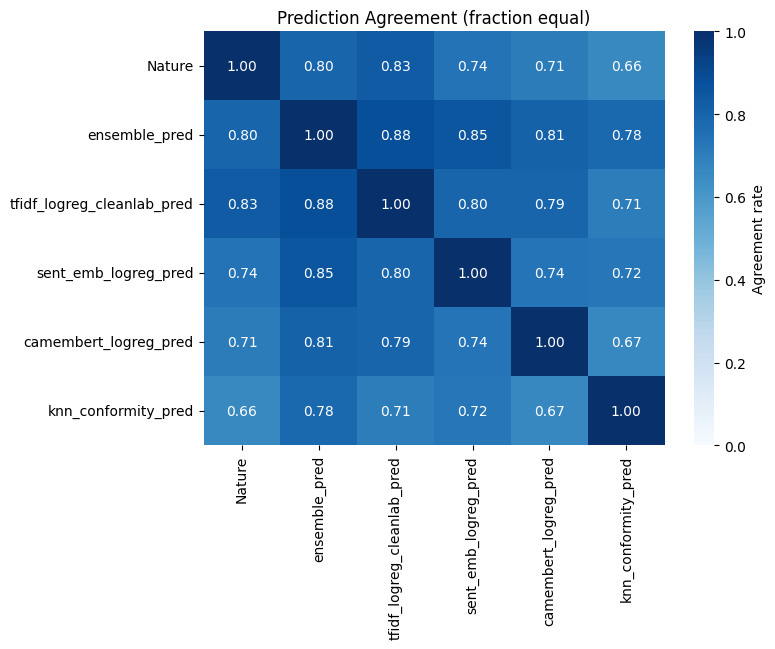

Saved agreement heatmap to artifacts/model_prediction_agreement_heatmap.png


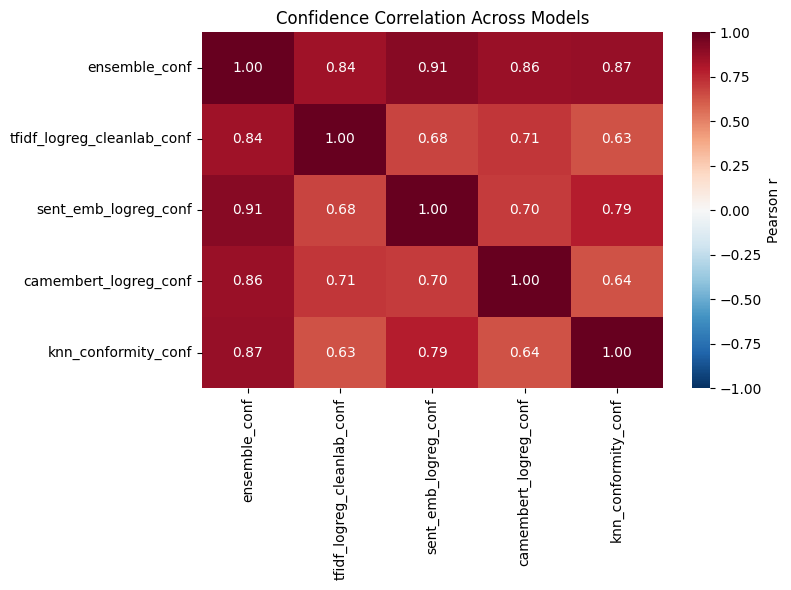

Saved confidence correlation heatmap to artifacts/model_confidence_correlation_heatmap.png


In [6]:
# Cross-correlation / agreement plots for model predictions and confidences
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Path to predictions file (update if needed)
results_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(results_path), f"Predictions file not found at {results_path}"

# Load predictions
pred_df = pd.read_csv(results_path)

# Identify label prediction columns
pred_cols = [c for c in pred_df.columns if c.endswith('_pred')]
if 'ensemble_pred' in pred_df.columns:
    pred_cols = list(dict.fromkeys(pred_cols + ['ensemble_pred']))

# Identify ground truth column(s) if present
gt_candidates = ['Nature', 'target', 'true_nature']
truth_cols = [c for c in gt_candidates if c in pred_df.columns]

label_cols = list(dict.fromkeys(truth_cols + pred_cols))
print('Label columns used:', label_cols)

# Compute pairwise agreement (fraction of exact match)
agreement = pd.DataFrame(index=label_cols, columns=label_cols, dtype=float)
for a in label_cols:
    for b in label_cols:
        mask = pred_df[a].notna() & pred_df[b].notna()
        if mask.any():
            agreement.loc[a, b] = (pred_df.loc[mask, a] == pred_df.loc[mask, b]).mean()
        else:
            agreement.loc[a, b] = np.nan

# Plot agreement heatmap
os.makedirs('artifacts', exist_ok=True)
plt.figure(figsize=(max(8, 1.1*len(label_cols)), max(6, 1.1*len(label_cols))))
sns.heatmap(agreement, annot=True, fmt='.2f', cmap='Blues', vmin=0, vmax=1, cbar_kws={'label': 'Agreement rate'})
plt.title('Prediction Agreement (fraction equal)')
plt.tight_layout()
agreement_path = 'artifacts/model_prediction_agreement_heatmap.png'
plt.savefig(agreement_path, dpi=200)
plt.show()
print('Saved agreement heatmap to', agreement_path)

# Confidence correlation across models (if available)
conf_cols = [c for c in pred_df.columns if c.endswith('_conf')]
if 'ensemble_conf' in pred_df.columns:
    conf_cols = list(dict.fromkeys(conf_cols + ['ensemble_conf']))

if len(conf_cols) >= 2:
    corr = pred_df[conf_cols].corr(method='pearson')
    plt.figure(figsize=(max(8, 1.1*len(conf_cols)), max(6, 1.1*len(conf_cols))))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', vmin=-1, vmax=1, cbar_kws={'label': 'Pearson r'})
    plt.title('Confidence Correlation Across Models')
    plt.tight_layout()
    corr_path = 'artifacts/model_confidence_correlation_heatmap.png'
    plt.savefig(corr_path, dpi=200)
    plt.show()
    print('Saved confidence correlation heatmap to', corr_path)
else:
    print('No or insufficient confidence columns found to plot correlation.')


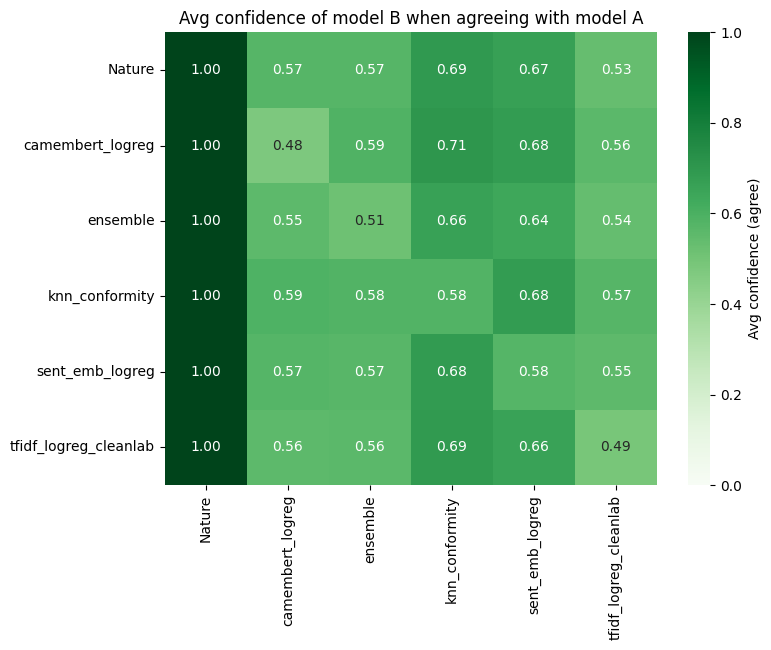

Saved artifacts/avg_conf_when_agree.png


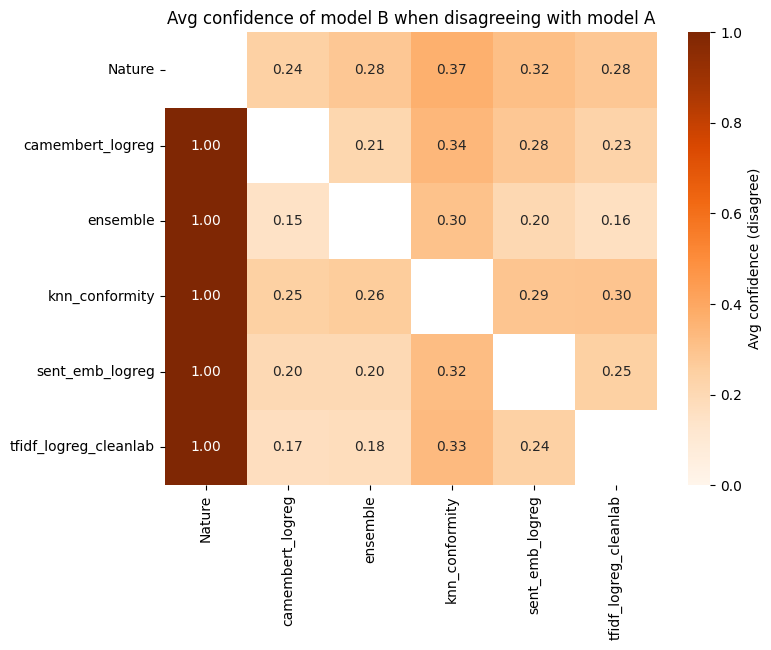

Saved artifacts/avg_conf_when_disagree.png


In [7]:
# Mixed plot: average confidence of model B conditioned on agreement with model A (and disagreement)
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Input predictions CSV
results_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(results_path), f"Predictions file not found at {results_path}"

df = pd.read_csv(results_path)

# Discover models from columns
pred_cols = [c for c in df.columns if c.endswith('_pred')]
conf_cols = [c for c in df.columns if c.endswith('_conf')]

# Include ensemble explicitly if present
if 'ensemble_pred' in df.columns and 'ensemble_conf' in df.columns:
    if 'ensemble_pred' not in pred_cols:
        pred_cols.append('ensemble_pred')
    if 'ensemble_conf' not in conf_cols:
        conf_cols.append('ensemble_conf')

# Optionally include ground truth Nature as a pseudo-model with 100% confidence
include_truth = 'Nature' in df.columns

# Build model name list from pred/conf pairs
# Model key is column prefix (remove _pred / _conf)
model_names = sorted({c[:-5] for c in pred_cols if c.endswith('_pred')})
# Add ensemble if present but not in the above set due to exact name match
if 'ensemble_pred' in pred_cols and 'ensemble' not in model_names:
    model_names.append('ensemble')

# Prepare accessors for prediction and confidence by model name
pred_for = {}
conf_for = {}
for name in model_names:
    pcol = f'{name}_pred'
    ccol = f'{name}_conf'
    if pcol in df.columns:
        pred_for[name] = df[pcol]
    elif name == 'ensemble' and 'ensemble_pred' in df.columns:
        pred_for[name] = df['ensemble_pred']
    if ccol in df.columns:
        conf_for[name] = df[ccol].astype(float)
    elif name == 'ensemble' and 'ensemble_conf' in df.columns:
        conf_for[name] = df['ensemble_conf'].astype(float)

# Include truth as a special model with 100% confidence
if include_truth:
    model_names_with_truth = ['Nature'] + model_names
else:
    model_names_with_truth = model_names.copy()

# Initialize matrices
agree_mat = pd.DataFrame(index=model_names_with_truth, columns=model_names_with_truth, dtype=float)
disagree_mat = pd.DataFrame(index=model_names_with_truth, columns=model_names_with_truth, dtype=float)

# Helper to get preds/conf series for a model key (or Nature)
def get_pred_series(name: str) -> pd.Series:
    if name == 'Nature':
        return df['Nature'].astype(str)
    return pred_for.get(name, pd.Series([np.nan] * len(df)))

def get_conf_series(name: str) -> pd.Series:
    if name == 'Nature':
        return pd.Series(np.ones(len(df), dtype=float))
    return conf_for.get(name, pd.Series([np.nan] * len(df)))

# Compute averages
for a in model_names_with_truth:
    pa = get_pred_series(a)
    for b in model_names_with_truth:
        pb = get_pred_series(b)
        cb = get_conf_series(b)
        mask_valid = pa.notna() & pb.notna() & cb.notna()
        if not mask_valid.any():
            agree_mat.loc[a, b] = np.nan
            disagree_mat.loc[a, b] = np.nan
            continue
        mask_agree = mask_valid & (pa == pb)
        mask_disagree = mask_valid & (pa != pb)
        agree_mat.loc[a, b] = float(cb[mask_agree].mean()) if mask_agree.any() else np.nan
        disagree_mat.loc[a, b] = float(cb[mask_disagree].mean()) if mask_disagree.any() else np.nan

# Plot and save
os.makedirs('artifacts', exist_ok=True)

plt.figure(figsize=(max(8, 1.1*len(model_names_with_truth)), max(6, 1.1*len(model_names_with_truth))))
sns.heatmap(agree_mat, annot=True, fmt='.2f', cmap='Greens', vmin=0, vmax=1, cbar_kws={'label': 'Avg confidence (agree)'})
plt.title('Avg confidence of model B when agreeing with model A')
plt.tight_layout()
agree_out = 'artifacts/avg_conf_when_agree.png'
plt.savefig(agree_out, dpi=200)
plt.show()
print('Saved', agree_out)

plt.figure(figsize=(max(8, 1.1*len(model_names_with_truth)), max(6, 1.1*len(model_names_with_truth))))
sns.heatmap(disagree_mat, annot=True, fmt='.2f', cmap='Oranges', vmin=0, vmax=1, cbar_kws={'label': 'Avg confidence (disagree)'})
plt.title('Avg confidence of model B when disagreeing with model A')
plt.tight_layout()
disagree_out = 'artifacts/avg_conf_when_disagree.png'
plt.savefig(disagree_out, dpi=200)
plt.show()
print('Saved', disagree_out)


                   model  count      rate  avg_conf  denom
4  tfidf_logreg_cleanlab   1921  0.034293  0.177917  56018
3        sent_emb_logreg    417  0.007444  0.266743  56018
2         knn_conformity    417  0.007444  0.348201  56018
0       camembert_logreg    293  0.005230  0.213711  56018
1               ensemble     66  0.001178  0.094219  56018


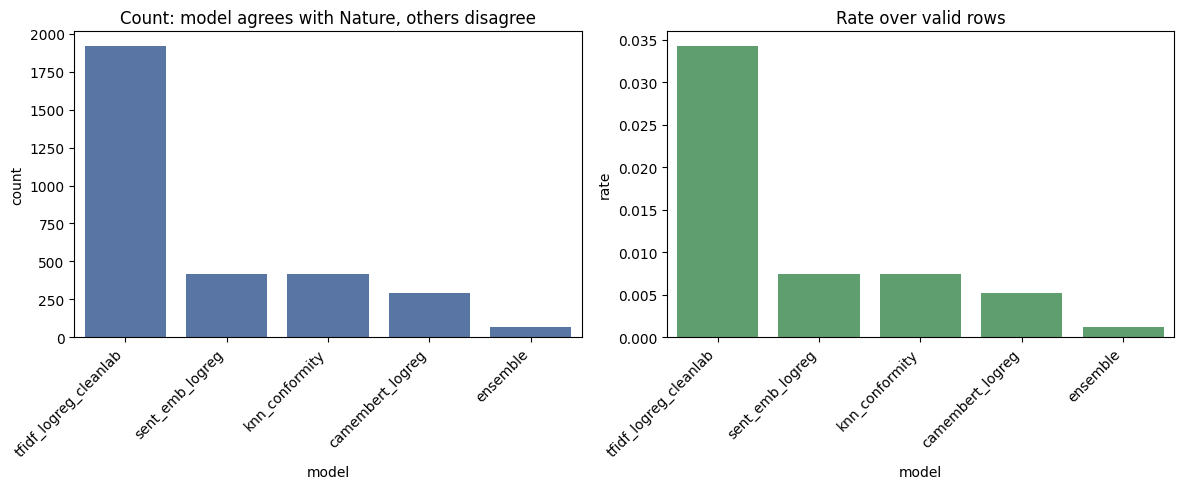

Saved plot to artifacts/models_standalone_correct.png


In [ ]:
# Plot: for each model, cases where it agrees with Nature while all other models disagree with Nature
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

preds_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(preds_path), f"Predictions file not found at {preds_path}"

df = pd.read_csv(preds_path)
if 'Nature' not in df.columns:
    raise ValueError("'Nature' ground-truth column not found in predictions file.")

# discover model prediction columns
pred_cols = [c for c in df.columns if c.endswith('_pred')]
# build model names from prefix
model_names = sorted({c[:-5] for c in pred_cols})

# helper to get a model's pred series
def pred_series(name: str) -> pd.Series:
    col = f'{name}_pred'
    if col in df.columns:
        return df[col].astype(str)
    return pd.Series([np.nan] * len(df), index=df.index)

nature = df['Nature'].astype(str)

rows = []
for m in model_names:
    pm = pred_series(m)
    mask_model_has = pm.notna()
    # other models list
    others = [o for o in model_names if o != m]
    if not others:
        continue
    # Build mask that all other available models disagree with Nature
    other_disagree_masks = []
    other_avail = []
    for o in others:
        po = pred_series(o)
        avail = po.notna()
        other_avail.append(avail)
        other_disagree_masks.append((po != nature) | (~avail))  # treat missing as neutral (doesn't block)
    # Combine to pandas Series
    all_others_disagree = pd.Series(
        np.logical_and.reduce([m.values for m in other_disagree_masks]), index=df.index
    ) if other_disagree_masks else pd.Series([True]*len(df), index=df.index)
    any_other_present = pd.Series(
        np.logical_or.reduce([a.values for a in other_avail]), index=df.index
    ) if other_avail else pd.Series([False]*len(df), index=df.index)
    # Model agrees with Nature
    agree_nature = (pm == nature)
    # Valid rows: model has pred and at least one other model present
    valid = mask_model_has & any_other_present
    target_mask = valid & agree_nature & all_others_disagree
    count = int(target_mask.sum())
    denom = int(valid.sum()) if int(valid.sum()) > 0 else 1
    rate = count / denom
    # confidence if available
    conf_col = f'{m}_conf'
    avg_conf = float(df.loc[target_mask, conf_col].mean()) if conf_col in df.columns and count > 0 else np.nan
    rows.append({'model': m, 'count': count, 'rate': rate, 'avg_conf': avg_conf, 'denom': denom})

res = pd.DataFrame(rows).sort_values('count', ascending=False)
print(res.head(10))

# plot
os.makedirs('artifacts', exist_ok=True)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=res, x='model', y='count', color='#4c72b0')
plt.title('Count: model agrees with Nature, others disagree')
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 2, 2)
sns.barplot(data=res, x='model', y='rate', color='#55a868')
plt.title('Rate over valid rows')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
out_path = 'artifacts/models_standalone_correct.png'
plt.savefig(out_path, dpi=200)
plt.show()
print('Saved plot to', out_path)


In [13]:
# Examples: for each model, 10 rows where it matches Nature and all others disagree
import os
import numpy as np
import pandas as pd

preds_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(preds_path), f"Predictions file not found at {preds_path}"

df = pd.read_csv(preds_path)
if 'Nature' not in df.columns:
    raise ValueError("'Nature' ground-truth column not found in predictions file.")

# discover model prediction columns
pred_cols = [c for c in df.columns if c.endswith('_pred')]
model_names = sorted({c[:-5] for c in pred_cols})

label_col = 'Libellé produit' if 'Libellé produit' in df.columns else None

# helper to get pred/conf series for a model
get_pred = lambda name: df.get(f'{name}_pred', pd.Series([np.nan]*len(df)))
get_conf = lambda name: df.get(f'{name}_conf', pd.Series([np.nan]*len(df))).astype(float)

nature = df['Nature'].astype(str)

out_dir = 'artifacts/standalone_correct_examples'
os.makedirs(out_dir, exist_ok=True)

previews = {}
for m in model_names:
    pm = get_pred(m).astype(str)
    others = [o for o in model_names if o != m]
    # masks across others
    other_disagree_masks = []
    other_avail = []
    for o in others:
        po = get_pred(o).astype(str)
        avail = po.notna()
        other_avail.append(avail)
        other_disagree_masks.append((po != nature) | (~avail))
    all_others_disagree = np.logical_and.reduce(other_disagree_masks) if other_disagree_masks else pd.Series([True]*len(df))
    any_other_present = np.logical_or.reduce(other_avail) if other_avail else pd.Series([False]*len(df))

    valid = pm.notna() & any_other_present
    target_mask = valid & (pm == nature) & all_others_disagree

    idx = list(np.where(target_mask.values)[0])
    np.random.shuffle(idx)
    idx = idx[:10]
    if not idx:
        continue
    cols = []
    if label_col:
        cols.append(label_col)
    cols += ['Nature']
    # add all model preds/confs
    for name in model_names:
        pcol = f'{name}_pred'
        ccol = f'{name}_conf'
        if pcol in df.columns:
            cols.append(pcol)
        if ccol in df.columns:
            cols.append(ccol)

    examples = df.loc[idx, cols]
    previews[m] = examples.head(3)
    examples.to_csv(os.path.join(out_dir, f'{m}_examples.csv'), index=False)

# show previews
for m, prev in previews.items():
    print(f"\n=== {m}: {len(prev)} of up to 10 examples (full saved to {out_dir}/{m}_examples.csv) ===")
    display(prev)



=== camembert_logreg: 3 of up to 10 examples (full saved to artifacts/standalone_correct_examples/camembert_logreg_examples.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf,knn_conformity_pred,knn_conformity_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf
29214,Mahio chaise suspendue brésilienne hamac balan...,Bain de soleil,Bain de soleil,0.107624,Hamac,0.119241,Ens table chaises,0.35,Hamac,0.255012,Hamac,0.131621
17862,Feuille tropicale,Decoration de noel,Decoration de noel,0.095193,Fauteuil,0.088450,Fauteuil,0.30,Objet deco,0.121170,Fauteuil,0.021615
15499,Ensemble bureau avec meuble de rangementet cha...,Bureau,Bureau,0.491505,Chaise de bureau,0.552938,Chaise de bureau,0.95,Chaise de bureau,0.696202,Chaise de bureau,0.488840



=== ensemble: 3 of up to 10 examples (full saved to artifacts/standalone_correct_examples/ensemble_examples.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf,knn_conformity_pred,knn_conformity_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf
46455,Surmatelas 90x190 cm,Meuble à chaussures,Surmatelas,0.282487,Meuble à chaussures,0.175976,Sommier,0.3,Sommier,0.189501,Surmatelas,0.382645
9296,Cartes micro sd evo plus 32 go,Acc telephonie,Pc portable,0.125748,Acc telephonie,0.068143,Matelas,0.2,Access. PC Tablette,0.093634,Pc portable,0.033223
42378,Roba table à langer pliable murale lovely bear,Table a langer,Table,0.108535,Table a langer,0.158428,Chevet,0.2,Table,0.174662,Table,0.210994



=== knn_conformity: 3 of up to 10 examples (full saved to artifacts/standalone_correct_examples/knn_conformity_examples.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf,knn_conformity_pred,knn_conformity_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf
13984,Dodo couette tempérée country 240 x 260 cm blanc,Accessoire ch adulte,Housse de couette,0.336670,Couette,0.302086,Accessoire ch adulte,0.35,Couette,0.259638,Couette,0.432225
47483,Table basse de salon stylée table d appoint av...,Table,Table basse,0.497394,Table basse,0.516755,Table,0.40,Table basse,0.680282,Table basse,0.489345
13679,Design metal lit double 160 x 200 cadre de lit...,Lit jeune,Lit adulte,0.832876,Lit adulte,0.684770,Lit jeune,0.55,Lit adulte,0.885228,Lit adulte,0.620975



=== sent_emb_logreg: 3 of up to 10 examples (full saved to artifacts/standalone_correct_examples/sent_emb_logreg_examples.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf,knn_conformity_pred,knn_conformity_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf
32842,Meuble de rangement rustique pin massif avec c...,Chiffonnier,Buffet,0.200991,Buffet,0.099078,Meuble à chaussures,0.2,Chiffonnier,0.094933,Commode,0.130874
34824,Montage Canapé 4 à 6 places Convertible,Montage Canapé,Canape droit,0.406263,Canape droit,0.252898,Canape droit,0.3,Montage Canapé,0.322853,Canape droit,0.254338
19160,Giantex oreiller de lecture coussin de soutien...,Oreiller,Matelas + sommier,0.119587,Matelas,0.310389,Matelas,0.9,Oreiller,0.121434,Matelas,0.132389



=== tfidf_logreg_cleanlab: 3 of up to 10 examples (full saved to artifacts/standalone_correct_examples/tfidf_logreg_cleanlab_examples.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf,knn_conformity_pred,knn_conformity_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf
42685,Ruban led 5m 5050 ip20 rgb 14w m dc12v 60led m,Guirlande lumineuse,Ampoule,0.082186,Centrale vapeur,0.080488,Centrale vapeur,0.30,Tv ecran plat,0.041351,Guirlande lumineuse,0.117237
29376,Marmite avec rev tement en marbre d 32 cm noir,Casserole,Objet deco,0.087747,Sommier,0.090503,Sommier,0.35,Plafonnier,0.064358,Casserole,0.047852
39789,Plateau de service antidérapant x3 design loft...,Plateau,Bureau,0.156477,Etagère,0.076037,Penderie,0.15,Etagère,0.234018,Plateau,0.114889


In [19]:
# For each model: up to 100 examples where the model disagrees with Nature (regardless of other models)
import os
import numpy as np
import pandas as pd

preds_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(preds_path), f"Predictions file not found at {preds_path}"

df = pd.read_csv(preds_path)
if 'Nature' not in df.columns:
    raise ValueError("'Nature' ground-truth column not found in predictions file.")

# discover model prediction columns
pred_cols = [c for c in df.columns if c.endswith('_pred')]
model_names = sorted({c[:-5] for c in pred_cols})

label_col = 'Libellé produit' if 'Libellé produit' in df.columns else None

out_dir = 'artifacts/disagree_with_nature'
os.makedirs(out_dir, exist_ok=True)

previews = {}
for m in model_names:
    pcol = f'{m}_pred'
    ccol = f'{m}_conf'
    if pcol not in df.columns:
        continue
    pred = df[pcol].astype(str)
    truth = df['Nature'].astype(str)
    mask = pred.notna() & df['Nature'].notna() & (pred != truth)
    idx = list(np.random.permutation(np.where(mask.values)[0]))[:100]
    if not idx:
        continue
    cols = []
    if label_col:
        cols.append(label_col)
    cols += ['Nature', pcol]
    if ccol in df.columns:
        cols.append(ccol)
    # optional ensemble context
    if 'ensemble_pred' in df.columns:
        cols.append('ensemble_pred')
    if 'ensemble_conf' in df.columns:
        cols.append('ensemble_conf')

    examples = df.loc[idx, cols]
    previews[m] = examples.head(5)
    examples.to_csv(os.path.join(out_dir, f'{m}_disagree_nature.csv'), index=False)

# Show small previews
for m, prev in previews.items():
    print(f"\n=== {m}: {len(prev)} of up to 100 examples (full saved to {out_dir}/{m}_disagree_nature.csv) ===")
    display(prev)



=== camembert_logreg: 5 of up to 100 examples (full saved to artifacts/disagree_with_nature/camembert_logreg_disagree_nature.csv) ===


,Libellé produit,Nature,camembert_logreg_pred,camembert_logreg_conf,ensemble_pred,ensemble_conf
3811,At4 portant à v tements essentiel h tre brut,Accessoire ch enfant,Portant,0.181871,Portant,0.089124
9768,Chaise de bar viktor en velours bleu 60 81 cm ...,Bar,Chaise,0.421966,Chaise,0.324022
23757,Lampe de chevet trépied attrape r ves rose atm...,Lampe,Chevet,0.187123,Lampe,0.575527
4747,Banc banquette style baroque accoudoirs courbé...,Tabouret,Fauteuil,0.063126,Tabouret,0.208948
5148,Barre de fixation extensible 70 100cm noir mat...,Paroi de douche,Accessoire sdb,0.090645,Paroi de douche,0.354694



=== ensemble: 5 of up to 100 examples (full saved to artifacts/disagree_with_nature/ensemble_disagree_nature.csv) ===


,Libellé produit,Nature,ensemble_pred,ensemble_conf,ensemble_pred,ensemble_conf
40510,Porteur enfants voiture 12 36 mois coffre klax...,Porteur et bascule,Lit jeune,0.166831,Lit jeune,0.166831
17578,Fauteuil relax ignifuger inclinable marron pu ...,Fauteuil,Fauteuil relax,0.288300,Fauteuil relax,0.288300
30906,Matelas ferme mi ferme 2en1 90x200,Meuble à chaussures,Matelas,0.721025,Matelas,0.721025
41867,Relax fauteuil de relaxation manuel simili noi...,Pouf / repose pied,Fauteuil,0.376984,Fauteuil,0.376984
8771,Canapé d angle réversible en tissu gabby 3 pla...,Friteuse,Canapé d'angle,0.648076,Canapé d'angle,0.648076



=== knn_conformity: 5 of up to 100 examples (full saved to artifacts/disagree_with_nature/knn_conformity_disagree_nature.csv) ===


,Libellé produit,Nature,knn_conformity_pred,knn_conformity_conf,ensemble_pred,ensemble_conf
40368,Porte pantalon en métal,Accessoire dressing,Cintres,0.15,Portant,0.165634
3293,Armoire lit escamotable kompact ouverture assi...,Armoire lit,Lit adulte,0.65,Lit adulte,0.277300
13642,Demi colonne,Colonne sdb,Objet deco,0.10,Colonne sdb,0.211095
31555,Matelas palette réversible l 120 x l 80 x h 15...,Fauteuil,Tapis de Salon et Ch,0.20,Matelas,0.089417
9200,Capital sports stream m1 rameur à résistance m...,Rameur,Petit outillage,0.15,Rameur,0.103952



=== sent_emb_logreg: 5 of up to 100 examples (full saved to artifacts/disagree_with_nature/sent_emb_logreg_disagree_nature.csv) ===


,Libellé produit,Nature,sent_emb_logreg_pred,sent_emb_logreg_conf,ensemble_pred,ensemble_conf
11421,Colle pour rats souris 135 g,Potager,Clavier souris,0.168058,Clavier souris,0.095804
41689,Rasoir femme rechargeable,Epilateur,Autre soin personne,0.088833,Rasoir homme,0.050842
23660,Lampe UV ongles,Autre soin personne,Lampe,0.442078,Lampe,0.337263
13815,Dessus en verre pour commode 6 tiroirs NEO,Dessus de meuble,Boite de rangement,0.089944,Commode,0.091135
651,mickey commode a langer 3 tiroirs sweetest li...,Table a langer,Commode,0.288882,Commode,0.339166



=== tfidf_logreg_cleanlab: 5 of up to 100 examples (full saved to artifacts/disagree_with_nature/tfidf_logreg_cleanlab_disagree_nature.csv) ===


,Libellé produit,Nature,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf,ensemble_pred,ensemble_conf
12849,Coussin 40x40 cm,Coussin,Housse de coussin,0.269793,Coussin,0.584837
51709,Tectake tente familiale 6 places gris clair gr...,Matériel camping,Salon de jardin,0.066995,Friteuse,0.104219
8638,Canapé d angle gauche convertible santiago gris,Friteuse,Canapé d'angle,0.633703,Canapé d'angle,0.770893
24601,Lena canapé d angle en tissu bleu canard conve...,Friteuse,Canapé d'angle,0.692271,Canapé d'angle,0.775973
42112,Rideau de douche modele madison,Abattant wc,Rideau de douche,0.257726,Rideau de douche,0.373653


In [16]:
# Find 100 examples where all models disagree with each other and with Nature
import os
import numpy as np
import pandas as pd

preds_path = 'artifacts/ensemble_predictions.csv'
assert os.path.exists(preds_path), f"Predictions file not found at {preds_path}"

df = pd.read_csv(preds_path)
if 'Nature' not in df.columns:
    raise ValueError("'Nature' ground-truth column not found in predictions file.")

# Collect model prediction columns (include ensemble if present)
pred_cols = [c for c in df.columns if c.endswith('_pred')]
model_names = sorted({c[:-5] for c in pred_cols})

nature = df['Nature'].astype(str)

# Build mask per-row: all model predictions present are pairwise-different and none equals Nature
def row_disagree_all(idx):
    vals = []
    for m in model_names:
        col = f'{m}_pred'
        if col in df.columns:
            v = df.at[idx, col]
            if pd.notna(v):
                vals.append(str(v))
    # require at least 2 predictions to avoid trivial rows
    if len(vals) < 2:
        return False
    # all different
    if len(set(vals)) != len(vals):
        return False
    # none equals Nature
    if any(v == nature.iat[idx] for v in vals):
        return False
    return True

mask = pd.Series([row_disagree_all(i) for i in range(len(df))], index=df.index)

# Select up to 100 rows
candidates = df[mask]
sel = candidates.head(100)

# Choose columns to save: label, Nature, per-model preds/conf if present
cols = []
if 'Libellé produit' in df.columns:
    cols.append('Libellé produit')
cols.append('Nature')
for m in model_names:
    pcol = f'{m}_pred'
    ccol = f'{m}_conf'
    if pcol in df.columns:
        cols.append(pcol)
    if ccol in df.columns:
        cols.append(ccol)

out_dir = 'artifacts'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'all_models_disagree_with_nature_100.csv')
sel.to_csv(out_path, index=False, columns=cols)
print(f'Saved {len(sel)} examples to {out_path}')
sel.head(5)


Saved 92 examples to artifacts/all_models_disagree_with_nature_100.csv


,Libellé produit,Univers,Nature,ensemble_pred,ensemble_conf,tfidf_logreg_cleanlab_pred,tfidf_logreg_cleanlab_conf,sent_emb_logreg_pred,sent_emb_logreg_conf,camembert_logreg_pred,camembert_logreg_conf,knn_conformity_pred,knn_conformity_conf
0,40 742 ensemble 5 en 1 tondeuse et regle barb...,Petit Electroménager,Tondeuse multistyle,Housse de couette,0.040864,Matelas + sommier,0.033730,Four,0.066967,Petit outillage,0.034106,Evier,0.15
195,clairage d urgence créatif bleu 35 ln 11cm de...,Décoration Textile,Objets lumineux,Pouf / repose pied,0.040985,Matelas,0.018365,Boite de rangement,0.123848,Bureau,0.027371,Lit adulte,0.15
205,coussinets d allaitement x6 lavable,Enfant Bébé,Accessoire allaitem.,Commode,0.054904,Coussin,0.025160,Chaise,0.106792,Oreiller,0.093222,Bibliotheque,0.15
796,pulvérisateur punaises de lits 1 l,Jardin Loisirs Sport,Potager,Housse de couette,0.032941,Chaise,0.030882,Tete de lit,0.054236,Accessoire jardin,0.064339,Cadre à lattes,0.10
2449,Amd amd athlon 3000g 3 5 ghz raven ridge socke...,TV Son Multimédia,Processeur,Friteuse,0.036706,Pc bureau,0.024267,Housse de couette,0.053728,Accessoire fitness,0.018528,Barrette mémoire,0.10
